In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
from datetime import datetime

import chess.pgn
import io
import re

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Allow max viewability for dataframes
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [55]:
# Reset viewability
pd.reset_option('display.max_rows')

In [3]:
chess_df = pd.read_csv('../../data/SampleGames_RU_1500_formatted.csv')

In [4]:
chess_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231559 entries, 0 to 231558
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   username      231559 non-null  object
 1   white_rating  231559 non-null  int64 
 2   black_rating  231559 non-null  int64 
 3   rating_diff   231559 non-null  int64 
 4   termination   231559 non-null  object
 5   ECO           231559 non-null  object
 6   total_moves   231559 non-null  int64 
 7   total_turns   231559 non-null  int64 
 8   moves_list    231559 non-null  object
 9   time_class    231559 non-null  object
 10  rated         231559 non-null  bool  
 11  date          231559 non-null  object
 12  year          231559 non-null  int64 
 13  month         231559 non-null  int64 
 14  day           231559 non-null  int64 
 15  white         231559 non-null  object
 16  black         231559 non-null  object
 17  pgn           231559 non-null  object
 18  fen           231559 non

In [5]:
chess_df['avg_rating'] = (chess_df['white_rating'] + chess_df['black_rating'])/2

In [6]:
# Convert date to datetime format
chess_df['date'] = pd.to_datetime(chess_df.date)

In [9]:
# Add column denoting what color user is
user_color = []
user_rating = []
for i in range(len(chess_df)):
    if eval(chess_df['white'][i])['username'].lower() == chess_df['username'][i].lower():
        user_color.append('white')
        user_rating.append(eval(chess_df['white'][i])['rating'])
    else:
        user_color.append('black')
        user_rating.append(eval(chess_df['black'][i])['rating'])
        
chess_df['user_color'] = user_color
chess_df['user_rating'] = user_rating

In [14]:
# View number of games in each category
print('bullet: ' + str(sum(chess_df['time_class'] == 'bullet')))
print('blitz: ' + str(sum(chess_df['time_class'] == 'blitz')))
print('rapid: ' + str(sum(chess_df['time_class'] == 'rapid')))
print('daily: ' + str(sum(chess_df['time_class'] == 'daily')))

bullet: 39419
blitz: 159269
rapid: 28837
daily: 4034


In [15]:
# Max-Min for ratings
print('White Max: ' + str(chess_df['white_rating'].max()))
print('Black Max: ' + str(chess_df['black_rating'].max()))
print('White Min: ' + str(chess_df['white_rating'].min()))
print('Black Min: ' + str(chess_df['black_rating'].min()))

White Max: 2997
Black Max: 3037
White Min: 100
Black Min: 100


### Turns per Game vs Average Rating Between Both Players

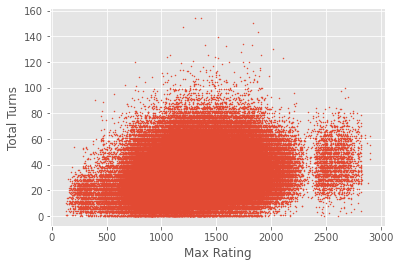

In [16]:
fig, ax = plt.subplots()
ax.scatter(chess_df['avg_rating'],chess_df['total_turns'],s=1)
ax.set_xlabel('Max Rating')
ax.set_ylabel('Total Turns')
plt.show()

In [17]:
# Create dataframes for each time class
bullet_df = chess_df[chess_df['time_class'] == 'bullet']
blitz_df = chess_df[chess_df['time_class'] == 'blitz']
rapid_df = chess_df[chess_df['time_class'] == 'rapid']
daily_df = chess_df[chess_df['time_class'] == 'daily']

### Turn Distribution per Time Class 

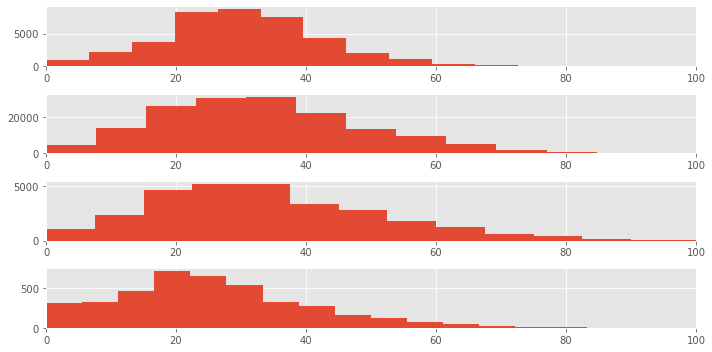

In [18]:
fig, axs = plt.subplots(4,1, figsize = (10,5))
axs[0].hist(bullet_df['total_turns'].values, bins=20)
axs[1].hist(blitz_df['total_turns'].values, bins=20)
axs[2].hist(rapid_df['total_turns'].values, bins=20)
axs[3].hist(daily_df['total_turns'].values, bins=20)

# Standardize axes limits for all graphs
plt.setp(axs, xlim=(0, 100))

plt.tight_layout()
plt.show()

# Year over Year Analysis

In [19]:
# Edge-case handling where game started in one year but completed in another
idx = chess_df[chess_df['year']==2016].index.values
for i in idx:
    chess_df.at[i,'year'] = 2015
    
idx = chess_df[chess_df['year']==2019].index.values
for i in idx:
    chess_df.at[i,'year'] = 2018

idx = chess_df[chess_df['year']==2021].index.values
for i in idx:
    chess_df.at[i,'year'] = 2020

In [20]:
for year in sorted(chess_df['year'].unique()):
    print(str(year) + ':')
    print('Mean: ' + str(chess_df[chess_df.year==year]['total_moves'].mean()))
    print('Standard Deviation: ' + str(chess_df[chess_df.year==year]['total_moves'].std()))
    print('Max: ' + str(chess_df[chess_df.year==year]['total_moves'].max()))
    print('Min: ' + str(chess_df[chess_df.year==year]['total_moves'].min()))

2015:
Mean: 70.37665847665848
Standard Deviation: 32.2443659527085
Max: 287
Min: 1
2018:
Mean: 68.30520405885686
Standard Deviation: 31.097125142696708
Max: 309
Min: 1
2020:
Mean: 64.69822352984991
Standard Deviation: 30.53440473693739
Max: 308
Min: 1


### Total Moves Distribution per Year

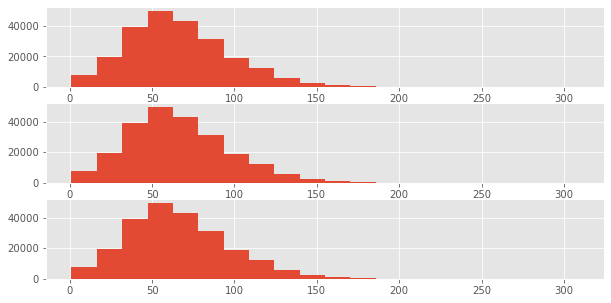

In [21]:
fig, axs = plt.subplots(3,1,figsize=(10,5))
for idx, year in enumerate(sorted(chess_df['year'].unique())):
    axs[idx].hist(chess_df['total_moves'].values, bins = 20)

plt.show()

In [22]:
chess_df.groupby('ECO').total_turns.mean().sort_values(ascending=False)

ECO
Alekhines-Defense-Scandinavian-Variation-3.exd5-Nxd5-4.Bc4-Nb6    130.0
Sicilian-Defense-Open-Dragon-Belezky-Line-8.Bc4                    86.0
Sicilian-Defense-Open-Dragon-Main-Line-9...Bd7-10.h4               85.0
English-Opening-Fianchetto-Ultra-Symmetrical-Duchamp-Variation     85.0
Polish-Opening-Schiffler-Sokolsky-Variation                        82.0
                                                                  ...  
Modern-Defense-Fianchetto-Gambit                                    4.0
Dutch-Defense-Alapin-Variation-Anti-Leningrad-Variation             3.0
Kings-Pawn-Opening-Kings-Knight-Irish-Gambit                        2.0
Barnes-Opening-Fools-Mate                                           2.0
Grob-Opening-Grob-Gambit-2...Bxg4                                   2.0
Name: total_turns, Length: 4438, dtype: float64

# Player Exploration

In [23]:
print('Total number of players: ' + str(len(chess_df['username'].unique())))

Total number of players: 383


In [24]:
# Top 10 players by number of games played
chess_df.groupby('username').count()['ECO'].sort_values(ascending=False).head(10)

username
aas521           3746
divididividi     3571
ufokosm777       3559
sagarns          3391
serggggggg       3056
kilelya          3046
pvladimirs       2932
marlenananyan    2828
zhenya-004       2771
tinkagain        2718
Name: ECO, dtype: int64

In [25]:
top_10 = list(chess_df.groupby('username').count()['ECO'].sort_values(ascending=False).head(10).index)

### Top 10 Players' Ratings over Time

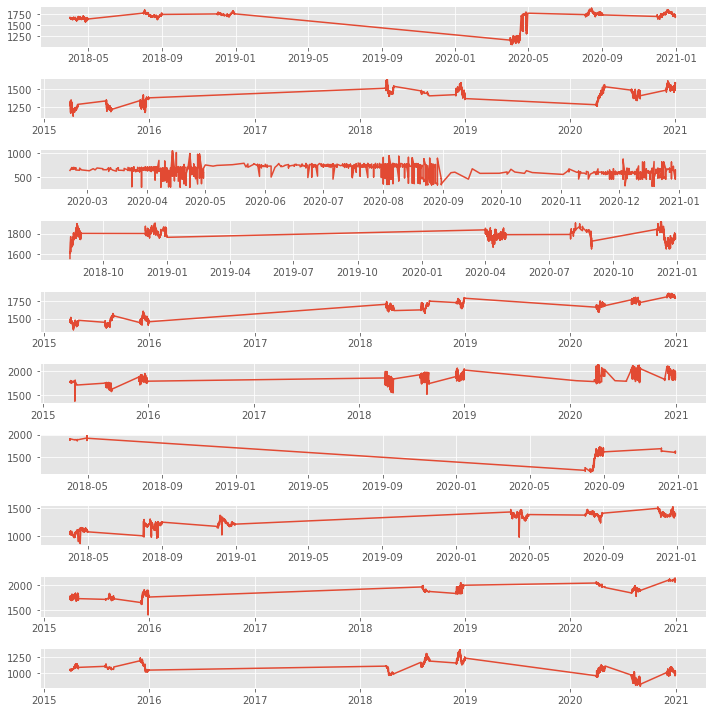

In [32]:
fig, axs = plt.subplots(10,1, figsize=(10,10))

for idx, player in enumerate(top_10):
    df = chess_df[chess_df.username==player].sort_values('date')
    axs[idx].plot(df.date, df.user_rating)
    
plt.tight_layout()
plt.show()

In [51]:
for user in top_10:
    print('Player: ' + user)
    print(chess_df[(chess_df.time_class=='blitz') & (chess_df.username==user)].sort_values('date').groupby(['year','month']).agg({'user_rating':['mean','min','max']}))
    
    

Player: aas521
            user_rating            
                   mean   min   max
year month                         
2018 4      1644.311881  1573  1705
     8      1725.853659  1623  1839
     9      1752.000000  1740  1764
     12     1754.345238  1684  1823
2020 4      1731.905172  1672  1790
     8      1765.571681  1682  1880
     9      1735.000000  1720  1750
     12     1734.736842  1632  1848
Player: divididividi
            user_rating            
                   mean   min   max
year month                         
2015 4      1237.812357  1131  1353
     8      1257.634483  1189  1350
     12     1308.348684  1180  1418
2018 1      1380.687500  1357  1410
     4      1501.447802  1405  1634
     8      1450.188679  1408  1483
     12     1481.079585  1380  1587
2020 1      1581.125000  1574  1591
     4      1442.009434  1268  1563
     5      1526.800000  1518  1534
     8      1423.501761  1344  1502
     9      1408.181818  1370  1438
     12     1524.540166  145

In [58]:
chess_df[(chess_df.time_class=='blitz') & (chess_df.username==top_10[0])].sort_values('date').groupby(['year','month']).agg({'user_rating':'mean'}).index[0]

(2018, 4)

### Top 10's Monthly Rating Averages over Time

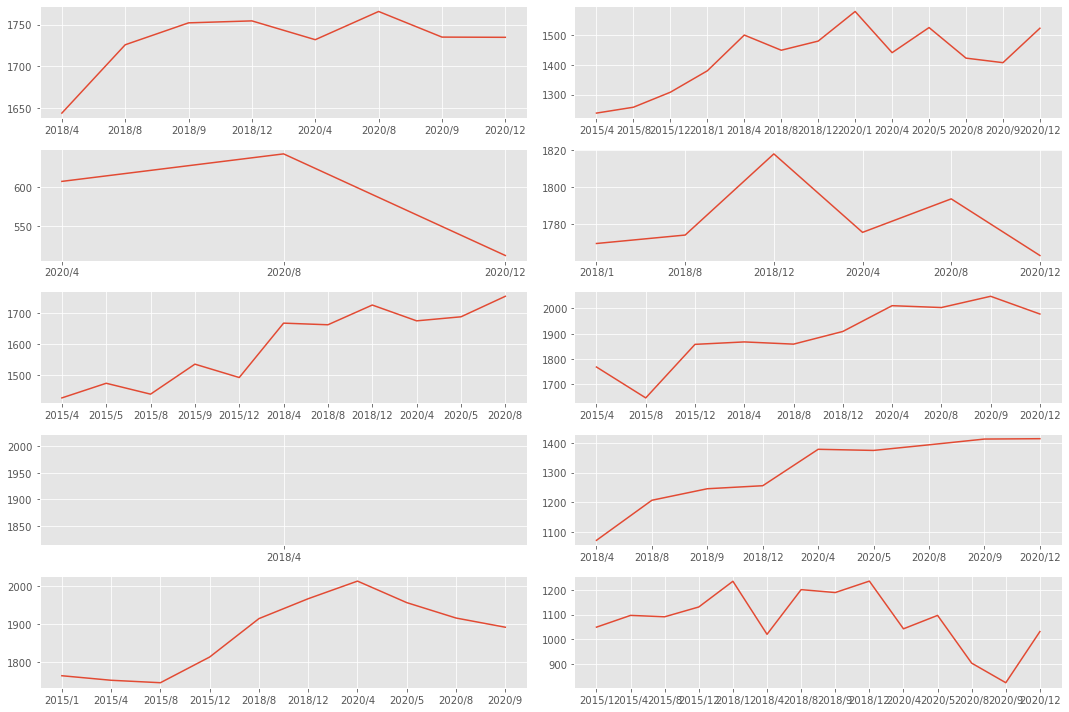

In [72]:
fig, axs = plt.subplots(5,2, figsize=(15,10))

for idx, ax in enumerate(axs.flatten()):
    df = chess_df[(chess_df.time_class=='blitz') & (chess_df.username==top_10[idx])].sort_values('date').groupby(['year','month']).agg({'user_rating':'mean'})
    ax.plot([str(i[0])+'/'+str(i[1]) for i in df.index], df.user_rating)
    
plt.tight_layout()
plt.show()

In [63]:
chess_df[(chess_df.time_class=='blitz') & (chess_df.username==top_10[0])].sort_values('date').groupby(['year','month']).agg({'user_rating':'mean'}).

2018

In [84]:
chess_df[(chess_df.username=='pvladimirs') & (chess_df.year==2018)]

,username,white_rating,black_rating,rating_diff,termination,ECO,total_moves,total_turns,moves_list,time_class,rated,date,year,month,day,white,black,pgn,fen,avg_rating,user_color,user_rating
10315,pvladimirs,1907,1865,42,joker7893 won on time,Scandinavian-Defense-Mieses-Kotrc-Variation-3....,82,41,"['e2e4', 'd7d5', 'e4d5', 'd8d5', 'b1c3', 'd5d8...",blitz,True,2018-04-02,2018,4,2,"{'rating': 1907, 'result': 'timeout', '@id': '...","{'rating': 1865, 'result': 'win', '@id': 'http...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",8/pp2p1k1/2p2n2/5P1n/3P3B/2P4N/PP5K/8 w - -,1886.0,white,1907
10316,pvladimirs,1873,1898,25,mamatov_valerij won by checkmate,Queens-Gambit-Declined-Queens-Knight-Variation...,65,32,"['d2d4', 'd7d5', 'c2c4', 'e7e6', 'b1c3', 'f8b4...",blitz,True,2018-04-02,2018,4,2,"{'rating': 1873, 'result': 'win', '@id': 'http...","{'rating': 1898, 'result': 'checkmated', '@id'...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",3nr3/p2R4/1p1k4/4NPp1/3P2P1/4P3/P5K1/8 b - -,1885.5,black,1898
10317,pvladimirs,1995,1888,107,Yuzbashi won on time,Modern-Defense-with-1-e4,75,37,"['e2e4', 'g7g6', 'g1f3', 'f8g7', 'd2d4', 'd7d6...",blitz,True,2018-04-02,2018,4,2,"{'rating': 1995, 'result': 'win', '@id': 'http...","{'rating': 1888, 'result': 'timeout', '@id': '...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",2Q3kr/pp3R2/3p4/3Pp1qB/1P2P3/P3b3/6P1/7K b - -,1941.5,black,1888
10318,pvladimirs,1868,1888,20,Game drawn by timeout vs insufficient material,Mieses-Opening,167,83,"['d2d3', 'd7d5', 'g2g3', 'e7e5', 'f1g2', 'c7c5...",blitz,True,2018-04-02,2018,4,2,"{'rating': 1868, 'result': 'timevsinsufficient...","{'rating': 1888, 'result': 'timevsinsufficient...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",8/6K1/8/5q2/p3k3/8/8/8 b - -,1878.0,black,1888
10319,pvladimirs,1878,1822,56,Plubz won - game abandoned,Ruy-Lopez-Opening-Berlin-Defense-4.O-O,38,19,"['e2e4', 'e7e5', 'g1f3', 'b8c6', 'f1b5', 'g8f6...",blitz,True,2018-04-02,2018,4,2,"{'rating': 1878, 'result': 'abandoned', '@id':...","{'rating': 1822, 'result': 'win', '@id': 'http...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",3r1rk1/1b1nbppp/p1q5/1pppP3/8/2P2N1P/PPBQ1PPB/...,1850.0,white,1878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138397,pvladimirs,1781,1911,130,PVladimirS won by resignation,Sicilian-Defense-Alapin-Variation-2...e6-3.d4,82,41,"['e2e4', 'e7e6', 'd2d4', 'c7c5', 'c2c3', 'c5d4...",blitz,True,2018-04-30,2018,4,30,"{'rating': 1781, 'result': 'resigned', '@id': ...","{'rating': 1911, 'result': 'win', '@id': 'http...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",4N2k/6p1/7p/3p1p2/8/p4PPK/1r5P/8 w - -,1846.0,black,1911
138398,pvladimirs,1898,1919,21,PVladimirS won by resignation,Modern-Defense-with-1-e4-2.d4-Bg7,102,51,"['e2e4', 'g7g6', 'd2d4', 'f8g7', 'c1e3', 'd7d6...",blitz,True,2018-04-30,2018,4,30,"{'rating': 1898, 'result': 'resigned', '@id': ...","{'rating': 1919, 'result': 'win', '@id': 'http...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",8/8/3p2pp/2p1k3/2P1P1P1/5KP1/1p6/1B4b1 w - -,1908.5,black,1919
138399,pvladimirs,1848,1926,78,PVladimirS won by resignation,Queens-Pawn-Opening-1...d6,24,12,"['d2d4', 'd7d6', 'c1f4', 'g7g6', 'e2e4', 'f8g7...",blitz,True,2018-04-30,2018,4,30,"{'rating': 1848, 'result': 'resigned', '@id': ...","{'rating': 1926, 'result': 'win', '@id': 'http...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",rn1q1r2/3bppkp/p2p1np1/2pP4/P3P3/2p2N2/1PPQBPP...,1887.0,black,1926
138400,pvladimirs,1934,1923,11,PVladimirS won by resignation,Italian-Game-Two-Knights-Defense-4.O-O,59,29,"['e2e4', 'e7e5', 'g1f3', 'b8c6', 'f1c4', 'g8f6...",blitz,True,2018-04-30,2018,4,30,"{'rating': 1934, 'result': 'win', '@id': 'http...","{'rating': 1923, 'result': 'resigned', '@id': ...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",4r1k1/1p4pp/4Pq2/3R1Pn1/1P4P1/P1N1Q2P/8/4R1K1 ...,1928.5,white,1934


In [87]:
chess_df.groupby('username').view()